In [30]:
import flwr
from flwr_datasets.partitioner import DirichletPartitioner
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from matplotlib import pyplot as plt
import csv
import os
import joblib
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import pandas as pd
import random
import numpy as np
import copy
import math

print(f"Flower {flwr.__version__} is installed")


Flower 1.17.0 is installed


In [31]:
def load_federated_data(num_clients, alpha, test_size, val_size):
    """
    Loads the CSV file, drops the 'attack_cat' column if present, and converts specified 
    non-numeric columns ("proto", "service", "state") to numeric using label encoding.
    The dataset is then split globally into training, validation, and test sets.
    The global training set is partitioned non-iid among clients using Flower's DirichletPartitioner.
    
    Args:
        num_clients (int): Number of federated clients.
        alpha (float): Dirichlet concentration parameter.
        test_size (float): Fraction of the overall data to reserve as test data.
        val_size (float): Fraction of the overall data to reserve as validation data.
        
    Returns:
        tuple: A tuple containing:
            - dict: A dictionary mapping client IDs to their local training DataFrame.
            - pd.DataFrame: The global test set.
            - pd.DataFrame: The global validation set.
            - dict: A dictionary mapping each of the categorical columns ("proto", "service", "state")
                    to its label encoder mapping (list of classes).
    """
    # Hard-coded file path and random seed
    file_path = "./Datasets/merged_UNSW_NB15.csv"
    random_state = 42

    # Load CSV into a pandas DataFrame and drop the 'attack_cat' column if it exists
    df = pd.read_csv(file_path)
    print("Original data shape:", df.shape)
    if "attack_cat" in df.columns:
        df.drop(columns=["attack_cat"], inplace=True)
        print("Dropped 'attack_cat'. New shape:", df.shape)

    
    # Label encoding for specified categorical columns
    label_encoders = {}
    for col in ["proto", "service", "state"]:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = {"classes": le.classes_.tolist()}
            print(f"Column '{col}' encoded with classes: {le.classes_.tolist()}")
    
    # Global split: first separate out the combined test+validation set.
    total_test_val = test_size + val_size
    global_train, global_test_val = train_test_split(
        df,
        test_size=total_test_val,
        stratify=df["label"],
        random_state=random_state
    )
    
    # Split the global test+validation set into separate test and validation sets.
    test_ratio = test_size / total_test_val
    global_test, global_val = train_test_split(
        global_test_val,
        test_size=(1 - test_ratio),
        stratify=global_test_val["label"],
        random_state=random_state
    )
    
    print("Global train shape:", global_train.shape)
    print("Global validation shape:", global_val.shape) if val_size != 0 else print("No validation set")
    print("Global test shape:", global_test.shape) if val_size != 0 else print("Global test shape:", global_test_val.shape)
    
    # Partition the global training data among clients using Flower's DirichletPartitioner.
    if num_clients == 1:
        # If there is only one client, return the entire training set as the client's training set.
        return {0: global_train}, global_test, global_val, label_encoders #Val is not needed for centralised
    hf_train_dataset = Dataset.from_pandas(global_train,preserve_index=False)
    partitioner = DirichletPartitioner(
        num_partitions=num_clients,
        partition_by="label",
        alpha=alpha,
        min_partition_size=2,
        self_balancing=True,
        shuffle=True,
        seed=random_state,
    )
    partitioner.dataset = hf_train_dataset
    
    client_train_dataset = {}
    
    
    # For each client, load the iid training partition.
    for client in range(num_clients):
        client_train = partitioner.load_partition(client).to_pandas()
        client_train_dataset[client] = client_train
        print(f"Client {client}: Train {client_train.shape}")
    
    return client_train_dataset, global_test, global_val, label_encoders


In [32]:
class MetricsTracker:
    def __init__(self, output_dir="metrics"):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        self.metrics = []

    def log_round_metrics(self, round_num, global_metrics, client_metrics, merge_method, num_clients, num_trees, max_depth, criterion):
        round_metrics = {
            "round_num": round_num,
            "merge_method": merge_method,
            "num_clients": num_clients,
            "num_trees": num_trees,
            "max_depth": max_depth,
            "criterion": criterion,
        }
        round_metrics.update(global_metrics)
        round_metrics.update(client_metrics)
        self.metrics.append(round_metrics)

    def save_metrics_to_csv(self, filename="metrics.csv"):
        keys = self.metrics[0].keys()
        with open(os.path.join(self.output_dir, filename), 'w', newline='') as output_file:
            dict_writer = csv.DictWriter(output_file, fieldnames=keys)
            dict_writer.writeheader()
            dict_writer.writerows(self.metrics)

    def plot_metrics(self):
        rounds = [m["round_num"] for m in self.metrics]
        accuracies = [m["global_accuracy"] for m in self.metrics]
        recalls = [m["global_recall"] for m in self.metrics]
        roc_aucs = [m["global_roc_auc"] for m in self.metrics]
        precisions = [m["global_precision"] for m in self.metrics]
        f1_scores = [m["global_f1_score"] for m in self.metrics]

        plt.figure(figsize=(10, 6))
        plt.plot(rounds, accuracies, label="Accuracy")
        plt.plot(rounds, recalls, label="Recall")
        plt.plot(rounds, roc_aucs, label="ROC AUC")
        plt.plot(rounds, precisions, label="Precision")
        plt.plot(rounds, f1_scores, label="F1 Score")
        plt.xlabel("Round")
        plt.ylabel("Score")
        plt.title("Global Model Metrics Over Rounds")
        plt.legend()
        plt.savefig(os.path.join(self.output_dir, "metrics_plot.png"))
        plt.show()

In [33]:
class ModelMerger:
    def __init__(self, global_val):
        """
        Initialize with the global validation dataset.
        This dataset is used for methods that need to evaluate model performance.
        """
        self.global_val = global_val

    def merge_models_randomly(self, client_models, num_input):
        # Collect all trees from all client models.
        all_trees = [tree for model in client_models for tree in model.estimators_]
        print("Number of trees in global model:", len(all_trees))
        selected_trees = random.sample(all_trees, min(len(all_trees), num_input))
        
        merged_model = RandomForestClassifier(n_estimators=0, warm_start=True)
        source_model = client_models[0]
        
        merged_model.n_features_in_ = source_model.n_features_in_
        merged_model.classes_ = source_model.classes_
        merged_model.n_classes_ = len(source_model.classes_)
        merged_model.n_outputs_ = 1
        if hasattr(source_model, 'feature_names_in_'):
            merged_model.feature_names_in_ = source_model.feature_names_in_
            
        merged_model.estimators_ = selected_trees
        merged_model.n_estimators = len(selected_trees)
        return merged_model

    def merge_models_by_impurity(self, client_models, num_input):
        all_trees = []
        # Collect all trees along with their root node impurity (lower is better)
        for model in client_models:
            for tree in model.estimators_:
                root_impurity = tree.tree_.impurity[0]
                all_trees.append((tree, root_impurity))
                
        sorted_trees = sorted(all_trees, key=lambda x: x[1])
        selected_trees = [tree for tree, _ in sorted_trees[:num_input]]
        print("Number of trees selected for global model:", len(selected_trees))
        
        merged_model = RandomForestClassifier(n_estimators=0, warm_start=True)
        source_model = client_models[0]
        merged_model.n_features_in_ = source_model.n_features_in_
        merged_model.classes_ = source_model.classes_
        merged_model.n_classes_ = len(source_model.classes_)
        merged_model.n_outputs_ = 1
        if hasattr(source_model, "feature_names_in_"):
            merged_model.feature_names_in_ = source_model.feature_names_in_
            
        merged_model.estimators_ = selected_trees
        merged_model.n_estimators = len(selected_trees)
        return merged_model

    def merge_models_best_acc(self, client_models, num_input):
        X_val = self.global_val.drop(columns=["label"]).values
        y_val = self.global_val["label"].values
        all_trees = [(tree, accuracy_score(tree.predict(X_val), y_val))
                     for model in client_models for tree in model.estimators_]
        best_trees = sorted(all_trees, key=lambda x: x[1], reverse=True)[:num_input]
        merged_model = RandomForestClassifier(n_estimators=len(best_trees), warm_start=True)
        merged_model.estimators_ = [tree for tree, _ in best_trees]
        return merged_model

    def merge_models_diversity(self, client_models, num_input):
        """
        Select trees to maximize feature diversity in the global model.
        """
        all_trees = [tree for model in client_models for tree in model.estimators_]
        # First, select a few of the best trees based on impurity.
        tree_impurities = [(tree, tree.tree_.impurity[0]) for tree in all_trees]
        sorted_trees = sorted(tree_impurities, key=lambda x: x[1])
        selected_trees = [tree for tree, _ in sorted_trees[:num_input // 4]]
        
        remaining_trees = [tree for tree, _ in sorted_trees[num_input // 4:]]
        feature_usage = {}
        # Initialize feature usage from already selected trees.
        for tree in selected_trees:
            for feature in self._get_important_features(tree):
                feature_usage[feature] = feature_usage.get(feature, 0) + 1
        
        # Greedy selection to maximize feature diversity.
        while len(selected_trees) < num_input and remaining_trees:
            best_tree = None
            best_score = None
            best_tree_idx = None
            for idx, tree in enumerate(remaining_trees):
                tree_features = self._get_important_features(tree)
                if not tree_features:
                    continue
                score = sum(feature_usage.get(feature, 0) for feature in tree_features) / len(tree_features)
                if best_tree is None or score < best_score:
                    best_tree = tree
                    best_score = score
                    best_tree_idx = idx
            if best_tree is None:
                break
            selected_trees.append(best_tree)
            remaining_trees.pop(best_tree_idx)
            for feature in self._get_important_features(best_tree):
                feature_usage[feature] = feature_usage.get(feature, 0) + 1
        
        merged_model = RandomForestClassifier(n_estimators=0, warm_start=True)
        source_model = client_models[0]
        merged_model.n_features_in_ = source_model.n_features_in_
        merged_model.classes_ = source_model.classes_
        merged_model.n_classes_ = len(source_model.classes_)
        merged_model.n_outputs_ = 1
        if hasattr(source_model, 'feature_names_in_'):
            merged_model.feature_names_in_ = source_model.feature_names_in_
        merged_model.estimators_ = selected_trees
        merged_model.n_estimators = len(selected_trees)
        return merged_model

    def merge_models_weighted_voting(self,client_models,num_input,min_acc=0.4,max_contrib=0.30,low_acc_contrib=0.05):
        """
        Weighted voting approach with custom constraints:
        1) Clients with accuracy < min_acc (0.4) can contribute at most low_acc_contrib (5%) of total trees.
        2) Any client can't exceed max_contrib (30%) of total trees.
        3) Leftover is distributed among top 30% of clients by accuracy.
        4) Within each client, we select the best trees by per-tree global accuracy.

        Parameters
        ----------
        client_models : list of RandomForestClassifier
            Each client's local model (RandomForest).
        num_input : int
            Total number of trees desired in the merged global model.
        min_acc : float
            Accuracy threshold for restricting client contribution. Below this => max 5% of total.
        max_contrib : float
            Maximum fraction of total trees a client can contribute.
        low_acc_contrib : float
            If client's accuracy < min_acc, it can contribute at most this fraction of total trees.

        Returns
        -------
        merged_model : RandomForestClassifier
            The merged global forest with constraints on contribution and
            best-tree selection per client.
        """

        # ----------------------------------------------------------------------
        # 1) Compute each client's overall accuracy on the global validation set
        # ----------------------------------------------------------------------
        X_val = self.global_val.drop(columns=["label"]).values
        y_val = self.global_val["label"].values

        # For patched probability, if needed:
        global_classes = np.sort(np.unique(y_val))

        client_scores = []
        for i, model in enumerate(client_models):
            try:
                # For each client's overall model accuracy:
                # Use patched probability if your code needs class alignment
                proba = ModelEvaluator.patched_predict_proba(model, X_val, global_classes)
                y_pred = global_classes[np.argmax(proba, axis=1)]
                acc = accuracy_score(y_val, y_pred)
            except Exception as e:
                print(f"Error scoring client {i} model with patched proba: {e}")
                acc = 0.0
            client_scores.append((i, acc))

        # Sort clients by descending accuracy
        sorted_by_acc = sorted(client_scores, key=lambda x: x[1], reverse=True)
        total_acc = sum(s for _, s in sorted_by_acc)

        # ----------------------------------------------------------------------
        # 2) Allocate fraction for each client with constraints
        #    - If client acc < min_acc => fraction <= low_acc_contrib
        #    - Otherwise fraction = (acc / total_acc), but <= max_contrib
        # ----------------------------------------------------------------------
        # We'll store fraction_of_trees in a dict, then do integer pass
        fractions = {}
        n_clients = len(client_models)

        # If total_acc == 0, fallback: distribute evenly or skip them all
        if total_acc == 0:
            # fallback approach
            for i, _ in sorted_by_acc:
                fractions[i] = 1.0 / n_clients  # or 0
        else:
            for i, acc in sorted_by_acc:
                if acc < min_acc:
                    # Force them to at most low_acc_contrib
                    frac = min(low_acc_contrib, 1.0)  # just in case
                else:
                    # Proposed fraction is (acc / total_acc)
                    proposed = (acc / total_acc)
                    # clamp to max_contrib
                    frac = min(proposed, max_contrib)
                fractions[i] = frac

        # Normalize fractions so they sum to <= 1
        # But some clients might be clamped, so sum_of_fractions could be < 1
        sum_frac = sum(fractions.values())
        # If sum_frac > 1, we reduce them proportionally
        if sum_frac > 1:
            for i in fractions:
                fractions[i] /= sum_frac
            sum_frac = 1.0

        # ----------------------------------------------------------------------
        # 3) Integer allocation + leftover distribution
        # ----------------------------------------------------------------------
        trees_per_client = {}
        leftover = num_input

        # First pass: integer allocation
        for i, acc in sorted_by_acc:
            frac = fractions[i]
            count = int(math.floor(frac * num_input))
            trees_per_client[i] = count
            leftover -= count

        # Now distribute leftover among top 30% of *scores* in round-robin
        top_k = max(1, int(0.3 * n_clients))
        top_slice = sorted_by_acc[:top_k]  # list of (client_idx, accuracy), best first
        idx_roundrobin = 0
        while leftover > 0 and top_slice:
            c_idx, _ = top_slice[idx_roundrobin]
            trees_per_client[c_idx] += 1
            leftover -= 1
            idx_roundrobin += 1
            if idx_roundrobin >= len(top_slice):
                idx_roundrobin = 0

        print("Trees allocated (before picking best trees per client):")
        for i in range(len(client_models)):
            print(f"Client {i} => {trees_per_client.get(i, 0)}")

        # ----------------------------------------------------------------------
        # 4) For each client, pick "trees_to_select" best trees by per-tree accuracy
        # ----------------------------------------------------------------------
        selected_trees = []
        for i, model in enumerate(client_models):
            trees_to_select = trees_per_client.get(i, 0)
            if trees_to_select <= 0:
                continue

            # Evaluate each tree's accuracy on global_val
            per_tree_scores = []
            for tree in model.estimators_:
                # Quick approach: accuracy on (X_val, y_val) for each tree
                # or patched if needed
                y_pred_tree = tree.predict(X_val)
                tree_acc = accuracy_score(y_val, y_pred_tree)
                per_tree_scores.append((tree, tree_acc))

            # Sort descending by accuracy
            per_tree_scores.sort(key=lambda x: x[1], reverse=True)

            # Take top N
            best_subset = [t for (t, s) in per_tree_scores[:trees_to_select]]
            selected_trees.extend(best_subset)

        # ----------------------------------------------------------------------
        # 5) Build final merged RandomForest
        # ----------------------------------------------------------------------
        merged_model = RandomForestClassifier(n_estimators=0, warm_start=True)

        # Use the first client as a reference for feature metadata, etc.
        # or you might keep track of the prior global model if needed
        source_model = client_models[sorted_by_acc[0][0]]  # best client by accuracy

        merged_model.n_features_in_ = source_model.n_features_in_
        all_classes = set(source_model.classes_)
        # Also unify with other clients' classes
        for cm in client_models:
            all_classes.update(cm.classes_)
        # unify with global test set classes
        all_classes.update(global_classes)

        merged_model.classes_ = np.array(sorted(all_classes))
        merged_model.n_classes_ = len(merged_model.classes_)
        merged_model.n_outputs_ = 1
        if hasattr(source_model, 'feature_names_in_'):
            merged_model.feature_names_in_ = source_model.feature_names_in_

        merged_model.estimators_ = selected_trees
        merged_model.n_estimators = len(selected_trees)

        print(f"Final number of selected trees: {len(selected_trees)}")
        return merged_model


    
    def merge_models_prune_similar(self, client_models):
        print("Number of trees in global model before prune:", sum(len(model.estimators_) for model in client_models))
        unique_trees = []
        pruned_client_models = []
        for model in client_models:
            pruned_estimators = []
            for tree in model.estimators_:
                if not any(self.are_trees_similar(tree, existing_tree) for existing_tree in unique_trees):
                    unique_trees.append(tree)
                    pruned_estimators.append(tree)
            pruned_model = RandomForestClassifier(n_estimators=len(pruned_estimators), warm_start=True)
            pruned_model.estimators_ = pruned_estimators
            pruned_client_models.append(pruned_model)
        print("Number of trees in global model after prune:", len(unique_trees))
        return pruned_client_models
    
    def merge_models_data_weighted(self, clients, client_and_models, num_input, alpha=0.5, beta=0.5):
        """
        Merge client models into a single RandomForestClassifier using a combination
        of data size and accuracy weighting.

        Parameters
        ----------
        clients : list of client objects
            Each client must have get_train_size().
        client_and_models : dict {client_obj -> RandomForestClassifier}
            The trained models for each client.
        num_input : int
            Total number of trees desired in the merged model.
        alpha : float
            Weight for accuracy in the combined weighting scheme.
        beta : float
            Weight for data size proportion in the combined weighting scheme.

        Returns
        -------
        merged_model : RandomForestClassifier
            A single scikit-learn RandomForestClassifier with the allocated trees
            from each client, proportional to the client's data size and accuracy.
        """

        X_val = self.global_val.drop(columns=["label"]).values
        y_val = self.global_val["label"].values
        global_classes = np.sort(np.unique(y_val))

        # Compute total data size across all clients
        total_size = sum(client.get_train_size() for client in clients)

        # ----------------------------------------------------------
        # 2) For each client, measure (accuracy, data_prop)
        # ----------------------------------------------------------
        client_info = []  # will store tuples: (client, accuracy, data_prop)
        for client in clients:
            model = client_and_models[client]
            # measure global accuracy
            try:
                # Possibly using your patched method to avoid class mismatch
                proba = ModelEvaluator.patched_predict_proba(model, X_val, global_classes)
                y_pred = global_classes[np.argmax(proba, axis=1)]
                acc = accuracy_score(y_val, y_pred)
            except Exception as e:
                print(f"Error scoring client {client}: {e}")
                acc = 0.0

            data_prop = (client.get_train_size() / total_size) if total_size > 0 else 0.0
            client_info.append((client, acc, data_prop))

        # ----------------------------------------------------------
        # 3) Compute combined_weight = alpha * acc + beta * data_prop
        # ----------------------------------------------------------
        weights = {}
        for (client, acc, dprop) in client_info:
            combined = alpha * acc + beta * dprop
            weights[client] = combined

        # Sum them, normalize so sum=1
        sum_w = sum(weights.values())
        if sum_w == 0:
            # fallback: distribute evenly if everything is zero
            for (client, _, _) in client_info:
                weights[client] = 1.0 / len(client_info)
            sum_w = 1.0
        else:
            for c in weights:
                weights[c] /= sum_w

        # ----------------------------------------------------------
        # 4) Integer allocation + leftover distribution
        # ----------------------------------------------------------
        # We create a fraction_of_trees for each client, then do floor().
        # We'll then distribute leftover among the top scoring clients in round-robin.
        client_tree_counts = {}
        leftover = num_input

        # Sort clients by fraction descending (so best fraction gets leftover first)
        sorted_by_fraction = sorted(weights.items(), key=lambda x: x[1], reverse=True)
        for c, frac in sorted_by_fraction:
            main_trees = int(math.floor(frac * num_input))
            client_tree_counts[c] = main_trees
            leftover -= main_trees

        # Distribute leftover in a simple round-robin among the top 30% by fraction
        n_clients = len(sorted_by_fraction)
        top_k = max(1, int(0.3 * n_clients))
        top_slice = sorted_by_fraction[:top_k]

        idx_rr = 0
        while leftover > 0 and top_slice:
            c, _ = top_slice[idx_rr]
            client_tree_counts[c] += 1
            leftover -= 1

            idx_rr += 1
            if idx_rr >= len(top_slice):
                idx_rr = 0

        print("[Data-Weighted Simple] Allocated trees (before picking best trees):")
        for c, n_trees in client_tree_counts.items():
            print(" ", c.client_id, "=>", n_trees)

        # ----------------------------------------------------------
        # 5) For each client, pick best trees by per-tree accuracy
        # ----------------------------------------------------------
        selected_trees = []
        for (client, acc, dprop) in client_info:
            model = client_and_models[client]
            trees_to_select = client_tree_counts[client]

            if trees_to_select <= 0:
                continue

            # Evaluate each tree individually
            per_tree_scores = []
            for tree in model.estimators_:
                # Evaluate on global_val
                y_pred_tree = tree.predict(X_val)
                tree_acc = accuracy_score(y_val, y_pred_tree)
                per_tree_scores.append((tree, tree_acc))

            # Sort descending by tree_acc
            per_tree_scores.sort(key=lambda x: x[1], reverse=True)

            # Take the top subset
            chosen = [t for (t, s) in per_tree_scores[:trees_to_select]]
            selected_trees.extend(chosen)

        # ----------------------------------------------------------
        # 6) Build the final merged RandomForest
        # ----------------------------------------------------------
        merged_model = RandomForestClassifier(n_estimators=0, warm_start=True)
        # As a reference "source_model," pick whichever had the highest fraction
        best_client = sorted_by_fraction[0][0]
        source_model = client_and_models[best_client]

        merged_model.n_features_in_ = source_model.n_features_in_

        # Unify classes across all models + the global set
        all_classes = set()
        for cl in clients:
            all_classes.update(client_and_models[cl].classes_)
        all_classes.update(global_classes)
        merged_model.classes_ = np.array(sorted(all_classes))
        merged_model.n_classes_ = len(merged_model.classes_)
        merged_model.n_outputs_ = 1

        if hasattr(source_model, 'feature_names_in_'):
            merged_model.feature_names_in_ = source_model.feature_names_in_

        merged_model.estimators_ = selected_trees
        merged_model.n_estimators = len(selected_trees)

        print(f"[Data-Weighted Simple] Merged with {len(selected_trees)} trees.")
        return merged_model


    def are_trees_similar(self, tree1, tree2, similarity_threshold=0.8):
        """Compare two trees based on their structure and parameters."""
        tree1_struct = tree1.tree_
        tree2_struct = tree2.tree_
        
        # If trees have very different node counts, they're not similar
        if abs(tree1_struct.node_count - tree2_struct.node_count) > 5:
            return False
        
        # Check only the first few nodes for efficiency.
        max_check_node = min(7, min(tree1_struct.node_count, tree2_struct.node_count))
        similar_nodes = 0
        for i in range(max_check_node):
            # If both nodes are leaf nodes, count as similar
            if tree1_struct.children_left[i] == -1 and tree2_struct.children_left[i] == -1:
                similar_nodes += 1
                continue
            
            # If one is leaf and the other is not, skip comparison.
            if (tree1_struct.children_left[i] == -1) != (tree2_struct.children_left[i] == -1):
                continue
                
            # Check if split features are the same and thresholds are close.
            if tree1_struct.feature[i] == tree2_struct.feature[i]:
                if abs(tree1_struct.threshold[i] - tree2_struct.threshold[i]) < 0.1:
                    similar_nodes += 1
        
        similarity = similar_nodes / max_check_node
        return similarity > similarity_threshold
    
    def _get_important_features(self, tree, importance_threshold=0.01):
        """Helper function to extract important features from a tree."""
        importances = tree.feature_importances_
        return [i for i, imp in enumerate(importances) if imp > importance_threshold]

In [34]:
class ModelEvaluator:
    """Utility class for evaluating models with patched predictions for class imbalance."""
    
    @staticmethod
    def patch_single_tree_proba(p, model_classes, global_classes):
        full_p = np.zeros((p.shape[0], len(global_classes)))
        for i, cls in enumerate(global_classes):
            if cls in model_classes:
                full_p[:, i] = p[:, model_classes == cls].flatten()
        return full_p
    
    @staticmethod
    def patched_predict_proba(model, X, global_classes):
        tree_probas = []
        for tree in model.estimators_:
            p = tree.predict_proba(X)
            tree_model_classes = tree.classes_
            patched_p = ModelEvaluator.patch_single_tree_proba(p, tree_model_classes, global_classes)
            tree_probas.append(patched_p)
        return np.mean(tree_probas, axis=0)
    
    @staticmethod
    def evaluate_model(model, X_test, y_test, model_name="Model", global_classes=None, quiet=False):
        if global_classes is None:
            global_classes = np.sort(np.unique(y_test))
            
        try:
            proba = ModelEvaluator.patched_predict_proba(model, X_test, global_classes)
            y_pred = global_classes[np.argmax(proba, axis=1)]
            
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred, average='macro',zero_division=0)
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro',zero_division=0)
            
            # Ensure y_test is a 1-dimensional array
            if y_test.ndim > 1 and y_test.shape[1] > 1:
                y_test = np.argmax(y_test, axis=1)
            
            try:
                if len(global_classes) == 2:
                    # For binary classification, use the probabilities for the positive class.
                    roc_auc = roc_auc_score(y_test, proba[:, 1])
                else:
                    # For multi-class classification.
                    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')
            except ValueError as e:
                print(f"Error calculating ROC AUC for {model_name}: {e}")
                roc_auc = None
            
            metrics = {
                "accuracy": accuracy,
                "recall": recall,
                "roc_auc": float(roc_auc),
                "precision": precision,
                "f1_score": f1
            }
            if quiet:
                return metrics
            else:
                print(f"{model_name} accuracy: {metrics.get('accuracy')}")
                return metrics
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
            return {
                "accuracy": None,
                "recall": None,
                "roc_auc": None,
                "precision": None,
                "f1_score": None
            }
    

In [35]:
class Server:
    def __init__(self, num_clients, clients_per_round, merge_method, num_global_trees, global_test_data, global_val_data, prune_similar):
        self.num_clients = num_clients
        self.clients_per_round = clients_per_round
        self.merge_method = merge_method
        self.num_global_trees = num_global_trees
        self.clients = []
        self.global_model = RandomForestClassifier(n_estimators=0, warm_start=True)
        self.global_test = global_test_data
        self.global_val = global_val_data
        self.model_merger = ModelMerger(self.global_val)
        self.prune_similar = prune_similar
        random.seed(42) # For reproducibility
        

    def register_client(self, client):
        self.clients.append(client)

    def select_clients(self):
      # Randomly choose clients each round
      
      available_clients = random.sample(self.clients, self.clients_per_round)
      print(f"Selected Clients: {[client.client_id for client in available_clients]}")
      return available_clients

    def merge_models(self, client_and_models):
        # Map merge method names to the corresponding ModelMerger method.
        merge_strategies = {
            "random": self.model_merger.merge_models_randomly,
            "best_acc": self.model_merger.merge_models_best_acc,
            "acc_weight_voting": self.model_merger.merge_models_weighted_voting,
            "impurity": self.model_merger.merge_models_by_impurity,
            "diversity": self.model_merger.merge_models_diversity,
            "data_weighted":self.model_merger.merge_models_data_weighted
            
        }
        clients = list(client_and_models.keys())
        client_models = list(client_and_models.values())
        if self.merge_method not in merge_strategies:
            raise ValueError(f"Invalid merge method: {self.merge_method}")
        # Some methods (like prune_similar) do not require the num_global_trees parameter.
        if self.merge_method == "data_weighted":
            return merge_strategies[self.merge_method](clients,client_and_models, self.num_global_trees)
        if self.prune_similar:
            pruned_client_models = self.model_merger.merge_models_prune_similar(client_models)
            return merge_strategies[self.merge_method](pruned_client_models, self.num_global_trees)
        return merge_strategies[self.merge_method](client_models, self.num_global_trees)

    def distribute_global_model(self):
        for client in self.clients:
            client.update_model(self.global_model)
        print("Global model distributed to all clients.")
    
    
    def evaluate_global_model(self):
        X_test = self.global_test.drop(columns=["label"]).values
        y_test = self.global_test["label"].values
        return ModelEvaluator.evaluate_model(self.global_model, X_test, y_test, "Global model")
    
    def validate_global_model(self):
        X_test = self.global_val.drop(columns=["label"]).values
        y_test = self.global_val["label"].values
        return ModelEvaluator.evaluate_model(self.global_model, X_test, y_test, "Global model validation")

    def get_model_size(self, model):
        """
        Dumps the model to a temporary file, gets its size in bytes, and then removes the file.
        """
        temp_file = 'temp_model.pkl'
        joblib.dump(model, temp_file)
        size = os.path.getsize(temp_file)
        os.remove(temp_file)
        return size
    
    def train_federated(self, configs):
        global_model_sizes = []      # Stores the global model size for each round
        round_local_avg_sizes = []   # Stores the average local model size for each round

        for round_num in range(1, configs["num_rounds"] + 1):
            print(f"\nStarting Round {round_num}")
            selected_clients = self.select_clients()
            round_models = {}
            client_metrics = {}

            # Train each selected client and gather their models
            for client in selected_clients:
                client.train(
                    configs["num_trees"],
                    configs["max_depth"],
                    configs["num_max_features"],
                    configs["n_jobs"]
                )
                print("Estimators:", client.model.n_estimators)
                round_models[client] = client.model

            print("\nTraining finished")

            # Calculate the average size of local models for this round
            local_sizes = [self.get_model_size(client.model) for client in selected_clients]
            avg_local_size_round = sum(local_sizes) / len(local_sizes)
            print(f"Average local model size for round {round_num}: {avg_local_size_round:.2f} bytes")
            round_local_avg_sizes.append(avg_local_size_round)

            # Merge models to get the global model
            if len(round_models) > 1:
                self.global_model = self.merge_models(round_models)
            else:
                self.global_model = next(iter(round_models.values()))
            print("\nMerged models")

            # Calculate the size of the global model for this round
            global_size = self.get_model_size(self.global_model)
            print(f"Global model size for round {round_num}: {global_size:.2f} bytes")
            global_model_sizes.append(global_size)

            # Evaluate global metrics and log round metrics
            if self.num_clients == 1:
                self.validate_global_model()#We only use this for centralised, did this to keep it clutter free.
            global_metrics = self.evaluate_global_model()
            if global_metrics is None:
                global_metrics = {
                    "accuracy": None,
                    "recall": None,
                    "roc_auc": None,
                    "precision": None,
                    "f1_score": None
                }
            metrics_tracker.log_round_metrics(
                round_num,
                {"global_" + k: v for k, v in global_metrics.items()},
                client_metrics,
                configs["merge_method"],
                configs["clients_per_round"],
                configs["num_trees"],
                configs["max_depth"],
                configs["criterion"]
            )

            print("\nEvaluating Round Results:")
            for client in selected_clients:
                client.evaluate()
            print("Round", round_num, "complete!")
            
            self.distribute_global_model()

        print("\nFederated Training Complete!")

        # Calculate and display the average sizes over all rounds.
        avg_global_model_size = sum(global_model_sizes) / len(global_model_sizes)
        avg_local_model_size = sum(round_local_avg_sizes) / len(round_local_avg_sizes)
        print(f"\nAverage Global Model Size over all rounds: {avg_global_model_size:.2f} bytes")
        print(f"Average Local Model Size over all rounds: {avg_local_model_size:.2f} bytes")

        metrics_tracker.save_metrics_to_csv()
        metrics_tracker.plot_metrics()


In [36]:
class Client:
    def __init__(self, client_id, train_data, test_data, model_params):
        self.client_id = client_id
        self.model_params = model_params
        self.model = RandomForestClassifier(**model_params)
        # Directly assign preprocessed training and test data
        self.train_data = train_data
        self.test_data = test_data

    def get_train_size(self):
        return self.train_data.shape[0]

    def train(self, num_trees, max_depth, num_max_features, n_jobs):
        print(f"Trees received from server at Client: {self.client_id} No Estimators: {self.model.n_estimators}")

        X_train = self.train_data.drop(columns=["label"]).values
        y_train = self.train_data["label"].values

        self.model.n_estimators = num_trees
        self.model.max_depth = max_depth
        self.model.max_features = num_max_features
        self.model.n_jobs = n_jobs
        self.model.fit(X_train, y_train)

        print(f"Client: {self.client_id} trained {self.model.n_estimators} trees")

        if configs["NUM_CLIENTS"] > 1 and configs["client_pruning"]:
            self.prune_redundant_trees()
        else:
            print("No pruning on client")


    def prune_redundant_trees(self):
        """
        An improved approach to prune redundant trees at the client level,
        without requiring validation data or server-side methods.
        """
        if self.model.n_estimators <= 5:
            return
            
        # Store original count for reporting
        tree_count_before_prune = self.model.n_estimators
        
        # Group trees with adaptive feature selection
        tree_groups = {}
        tree_variance = {}  # Store variance of predictions for proxy diversity measure
        
        # Generate a small synthetic dataset for diversity measurement
        # This is just to compare trees, not for validation
        n_features = len(self.model.estimators_[0].feature_importances_)
        synthetic_X = np.random.randn(50, n_features)  # 50 random samples
        
        for i, tree in enumerate(self.model.estimators_):
            # Get feature importances
            importances = tree.feature_importances_
            
            # Select top 3-5 features based on importance threshold
            # This is more adaptive than fixed top 3
            sorted_idx = np.argsort(importances)[::-1]  # Descending order
            threshold = 0.7  # Features accounting for 70% of importance
            cumsum = np.cumsum(importances[sorted_idx])
            n_features_to_use = min(5, max(3, np.searchsorted(cumsum, threshold) + 1))
            top_features = sorted_idx[:n_features_to_use]
            
            # Create signature from adaptive number of top features
            signature = tuple(sorted(top_features))
            tree_groups.setdefault(signature, []).append(i)
            
            # Calculate variance of predictions as a proxy for tree diversity
            # Higher variance = more unique predictions = more diverse tree
            tree_preds = tree.predict(synthetic_X)
            tree_variance[i] = np.var(tree_preds)
        
        pruned_trees = []
        
        # Process each group with smarter selection
        for signature, group in tree_groups.items():
            if len(group) <= 2:
                # Keep all trees in small groups
                for idx in group:
                    pruned_trees.append(self.model.estimators_[idx])
            else:
                # Adapt retention rate based on group size
                if len(group) < 7:
                    retention_rate = 0.8  # Keep 80% for small groups
                elif len(group) < 15:
                    retention_rate = 0.6  # Keep 60% for medium groups
                else:
                    retention_rate = 0.4  # Keep 40% for large groups
                    
                keep_count = max(2, math.ceil(len(group) * retention_rate))
                
                # Select diverse trees based on prediction variance
                sorted_group = sorted(group, key=lambda idx: tree_variance[idx], reverse=True)
                selected_indices = sorted_group[:keep_count]
                    
                for idx in selected_indices:
                    pruned_trees.append(self.model.estimators_[idx])
        
        # Update model with pruned trees
        self.model.estimators_ = pruned_trees
        self.model.n_estimators = len(pruned_trees)
        
        print(f"Pruned {tree_count_before_prune - self.model.n_estimators} trees from client {self.client_id}. "
            f"Total Trees: {self.model.n_estimators} "
            f"({(tree_count_before_prune - self.model.n_estimators)/tree_count_before_prune:.1%} reduction)")
        
    def evaluate(self, global_classes=None):
        X_test = self.test_data.drop(columns=["label"]).values
        y_test = self.test_data["label"].values
        model_name = f"Client {self.client_id}"
        return ModelEvaluator.evaluate_model(self.model, X_test, y_test, model_name, global_classes)


    def update_model(self, global_model):
        self.model = copy.deepcopy(global_model)

Original data shape: (257672, 45)
Dropped 'attack_cat'. New shape: (257672, 44)
Column 'proto' encoded with classes: ['3pc', 'a/n', 'aes-sp3-d', 'any', 'argus', 'aris', 'arp', 'ax.25', 'bbn-rcc', 'bna', 'br-sat-mon', 'cbt', 'cftp', 'chaos', 'compaq-peer', 'cphb', 'cpnx', 'crtp', 'crudp', 'dcn', 'ddp', 'ddx', 'dgp', 'egp', 'eigrp', 'emcon', 'encap', 'etherip', 'fc', 'fire', 'ggp', 'gmtp', 'gre', 'hmp', 'i-nlsp', 'iatp', 'ib', 'icmp', 'idpr', 'idpr-cmtp', 'idrp', 'ifmp', 'igmp', 'igp', 'il', 'ip', 'ipcomp', 'ipcv', 'ipip', 'iplt', 'ipnip', 'ippc', 'ipv6', 'ipv6-frag', 'ipv6-no', 'ipv6-opts', 'ipv6-route', 'ipx-n-ip', 'irtp', 'isis', 'iso-ip', 'iso-tp4', 'kryptolan', 'l2tp', 'larp', 'leaf-1', 'leaf-2', 'merit-inp', 'mfe-nsp', 'mhrp', 'micp', 'mobile', 'mtp', 'mux', 'narp', 'netblt', 'nsfnet-igp', 'nvp', 'ospf', 'pgm', 'pim', 'pipe', 'pnni', 'pri-enc', 'prm', 'ptp', 'pup', 'pvp', 'qnx', 'rdp', 'rsvp', 'rtp', 'rvd', 'sat-expak', 'sat-mon', 'sccopmce', 'scps', 'sctp', 'sdrp', 'secure-vmtp', 

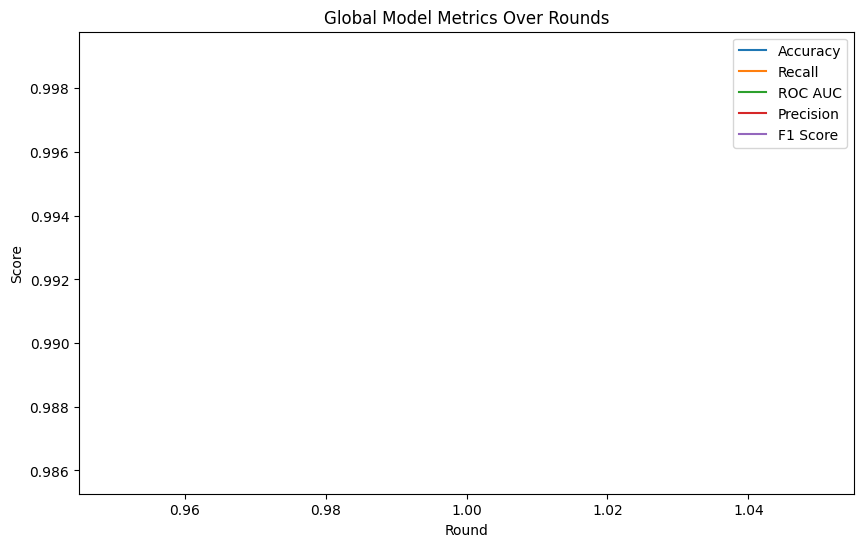

In [37]:
from timeit import default_timer as timer
global configs
configs = {
    #Federated Features
    "NUM_CLIENTS": 1,# If you set the client as 1 it will be centralized training, you should also set the size of val to 0 aswell then
    "clients_per_round": 1,
    "global_num_trees": 30,
    "num_rounds": 1,
    "merge_method": "best_acc",# random, best_acc, acc_weight_voting, data_weighted, impurity, diversity, prune_similar
    "prune_similar": False,
    "client_pruning": False,
    #Training parameters
    "num_trees": 60,
    "max_depth": None,#maybe none
    "num_max_features": 14,
    "n_jobs": -1,
    #Data features partition
    "test_size": 0.2, 
    "val_size": 0.1, #There should be a val dataset even for centralized for quality checks.
    "dirichlet_alpha": 0.8,
    #Model parameters
    "criterion": "gini", # or "entropy"
}
#1000 clients, 5-10 participating pre round, 50 trees sent from server 100 trees train to?   


# Load federated data
start = timer()
client_train_dataset, global_test, global_val, label_encoders = load_federated_data(
    num_clients=configs["NUM_CLIENTS"],
    alpha=configs["dirichlet_alpha"],
    test_size=configs["test_size"],
    val_size=configs["val_size"]
)
end = timer()
print("Time Elapsed running load data:", end - start)

metrics_tracker = MetricsTracker()

# Initialize server
server = Server(
    num_clients=configs["NUM_CLIENTS"],
    clients_per_round=configs["clients_per_round"],
    merge_method=configs["merge_method"],
    num_global_trees=configs["global_num_trees"],
    global_test_data=global_test,
    global_val_data=global_val,
    prune_similar=configs["prune_similar"]
)


# Register clients
for client_id, client_train in client_train_dataset.items():
    client = Client(
        client_id,
        client_train,       # local training data
        global_test,        # global test set
        {"n_estimators": 0,
         "warm_start": True,
         "bootstrap": True,
         "criterion": configs["criterion"],}
    )
    server.register_client(client)

# Run federated training
server.train_federated(configs)


In [38]:
#Client specific models so merge for client model and global model at client side.
#use the same data set as victor
#pruning on client side? maybe if using large data set.
#global mode and client model might not be the same.
#define client models they will not use the server side model
#lit review about fed learning 3 -4 pages random forrest dec trees (2 pgs)
# anomly detection related work 3- 4 pages
#intro(2) and problem statement (1) goals (1)
#describe how you design the system (10) merdging aswell
#results analysis tables charts (5pgs)
#conclusion future work (2pgs)
#thursday 11.30 every week. with victor


#I have things that I am not doing. Like privacy or communication overhead. I dont touch on those topics in my implementation.
#Should I mention them in my paper especially in the background and say that I am not doing them?
#Should this paper be more about an implementation of federated learning rather than the actual federated learning itself? Where I look at experimentation and results?
#Challanges of IoT and FL is data is not labelled in real world. What should I write about this? 

# Meeting Agenda

## Overview

- **Explain what I have so far**

## Data Preprocessing

- No normalisation, tree models don’t benefit from this.
- Drop `attack_cat` as this will be binary exclusively.
- Proceed to label string data.
- Split the data into train/test/validation sets.
- Train data goes through Dirichlet partition.

## Server Logic

### Clients Setup
- Define number of clients.
- Define number that train each round.
- Server selects clients randomly.

### Training
- Server trains each client.
- Models are just replaced with the global model at client side; there is no averaging or any additional logic.

### Merging Methods
- I have separate logic for merging with **5 different methods**:
  - Random
  - Weight_global
  - Weight_voting
  - Impurity
  - Diversity
- Also have the option to prune similar trees.

## Data Collection and Evaluation

### Data Collection Class
- Concerned with accuracies and plotting them mainly.

### Evaluator Class
- Needed because some trees don’t have all the classes so I need to do patching.
- This allows sharing code between client and global models.

## Tracking Metrics

### Per Round
- Round number
- Accuracy
- Recall
- ROC AUC
- Precision
- F1 scores
- The clients that participate that round (not sure if this is necessary)

### Global Settings (Not Round Specific)
- Number of trees that server gives to clients
- Number of trees the clients train up to
- Merge method being used
- Number of clients participating
- Criterion 
- (whether using pruning or not on server)

### Additional Tracking
- Client distributions for each experiment to show non-IIDness.

## Experiment Considerations

### Parameters to Vary
- Tree parameters (start with fewer/more trees)
- Merge method being used
- Criterion 
- (pruning on the server or not)
- Max depth and Max features (unsure if these are useful in federated learning)

### Request for Input
- Would like suggestions on what exactly to focus on during experiments.
- Should client selection and partitioning be deterministic for experiments. I feel like it should be. 
